In [1]:
#%pip install networkx==1.11
#%pip uninstall networkx && pip install networkx
#%pip install scipy

# FBox

A fix : probleme il prend toujours le dernier sinon rien
et bcp de probleme avec matlab voir commentaires

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.io import savemat, loadmat
import os

import pylab

In [3]:
def plot_graph(A):
    G = nx.DiGraph()
    for count,value in enumerate(A):
        for count2, value2 in enumerate(value):
            if (value2 != 0):
                G.add_edges_from([(str(count), str(count2))], weight=value2)

    edge_labels=dict([((u,v,),d['weight'])
                    for u,v,d in G.edges(data=True)])

    pos=nx.spring_layout(G)
    
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nx.draw(G,pos,edge_cmap=plt.cm.Reds,with_labels = True)
    #nx.draw(G,pos,edge_cmap=plt.cm.Reds,with_labels = True,connectionstyle='arc3, rad = 0.3')
    pylab.show()

In [4]:
#==========   Initialisation
pcthresh = 1
degthresh = 2
neigs = 3#Utilite enleve

#[!] Il check ligne ou colonne (car matlab inverse)??? actuellement ligne ???
graph = [
    [0, 5 ,2 ,4],
    [1, 0, 5, 3],
    [ 5 ,5 ,5, 0],
    [ 0, 0, 0, 0],
]

graph = np.array(graph)
#graph = np.transpose(graph)
#graph[graph>0] = 1

adj = csc_matrix(graph, dtype=float)
#A = csc_matrix([[1, 0, 0], [5, 0, 2], [0, -1, 0], [0, 0, 3]], dtype=float)

  (1, 0)	1.0
  (2, 0)	5.0
  (0, 1)	5.0
  (2, 1)	5.0
  (0, 2)	2.0
  (1, 2)	5.0
  (2, 2)	5.0
  (0, 3)	4.0
  (1, 3)	3.0
attention les edges s overlap


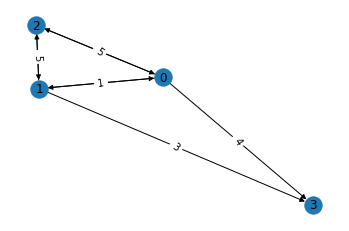

In [5]:
#============ On affiche le graphe de liens

print(adj)
print("attention les edges s overlap")
plot_graph(graph)

Probleme : A = graph ou A=adj

In [6]:
#Le A de matlab est adj ou graph ???? (les deux marchent sous matlab mais res diff)
A = adj.toarray()

In [11]:
mat = loadmat('../data_out/data_amz.mat')
adj = mat['M'].asfptype()
adj = adj.transpose()

# Implementation du code

Code a partir de son algo ecris sur son papier

In [18]:
def fbox(A, k, t):
    userCulprits   = []
    objectCulprits = []
    outDegrees     = np.sum(A, 0)
    inDegrees      = np.sum(A, 1)
    U, S, V        = svds(A, k=k,which="LM",return_singular_vectors=True)
    

    print("nb out degre 0 (5)",outDegrees[0,1])# doit etre a 5
    print("nb out degre 0 (1)",inDegrees[1,0])# doit etre a 1


    S = np.diag(S)#pour avoir une vrai matrice plutot qu'un vecteur
    #print((U @ S).shape)
    recOutDegs = np.square(np.linalg.norm( U @ S,axis=1))
    recInDegs  = np.square(np.linalg.norm( np.transpose(V) @ S,axis=1))


    #recOutDegs = np.square(np.linalg.norm(U*S, axis=1))
    #recInDegs  = np.square(np.linalg.norm(np.transpose(V)*S, axis=1))

    
    uniqueOutDegrees = np.unique(np.array(outDegrees))
    uniqueInDegrees  = np.unique(np.array(inDegrees))
    

    for od in uniqueOutDegrees:
        nodeSet = np.where(uniqueOutDegrees == od)[0]
        recOutDegSet = recOutDegs[nodeSet]
        recThreshold = np.percentile(recOutDegSet, t)
        for n in nodeSet:
            if(recOutDegs[n] <= recThreshold):
                userCulprits.append(n)
                #userCulprits.append((n,recOutDegs[n]))
            
    for ind in uniqueInDegrees:
        nodeSet = np.where(uniqueInDegrees == ind)[0]
        recInDegSet = recInDegs[nodeSet]
        recThreshold = np.percentile(recInDegSet, t)
        for n in nodeSet:
            if(recInDegs[n] <= recThreshold):
                objectCulprits.append(n)
                #objectCulprits.append((n,recInDegs[n]))
    
    return userCulprits, objectCulprits

Code a partir de son matlab

In [24]:
#https://stackoverflow.com/questions/24764966/numpy-percentile-function-different-from-matlabs-percentile-function
def quantile(x,q):#Equivalent de np.quantile
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p):#Equivalent matlab
    return(np.quantile(x,np.array(p)/100))

def find(cond):#Equivalent matlab
    return np.where(cond)

#Version matlab de son algo
def m_fbox(A, k, t):

    U,S,V = svds(A,k=k,which="LM",return_singular_vectors=True)
    S = np.diag(S)
    V = np.transpose(V)
    
    #On inverse l'ordre des colonnes et on multiplie par -1
    U = -1 * np.fliplr(U)
    V = -1 * np.fliplr(V)
    S =  np.fliplr(S)
    S = np.flipud(S)
    
    #Le check est bon (normalement)
    #check = np.matmul(np.matmul(U,S),np.transpose(V))
    #print("check: ",check)
    #normalement check == A (a quelques arrondi de neigs pres)

    indegs = np.sum(A,axis=0).A1#On retransforme la matrice sous forme array
    outdegs = np.sum(A,axis=1).A1

    rec_indegs = np.sum(np.matmul(V,S) ** 2,axis=1)#Meme que matlab
    rec_outdegs = np.sum(np.matmul(U,S) ** 2,axis=1)#Meme que matlab


    q = np.unique(np.array(indegs))
    lq = len(q)

    #On pourrait changer en array de tuple
    trackpct_indegs = lil_matrix((lq,2))

    for i in range(0,lq):
        deg = q[i]
        trackpct_indegs[i,0] = deg
        indices = find(indegs == deg)
        vsub = V[indices,:]
        rdegs = np.sum( np.matmul(vsub,S) **2,axis=1)
        trackpct_indegs[i,1] = prctile(rdegs,pcthresh)
        

    q = np.unique(np.array(outdegs))
    lq = len(q)
    trackpct_outdegs = lil_matrix((lq,2))
    for i in range(0,lq):
        deg = q[i]
        trackpct_outdegs[i,0] = deg
        indices = find(outdegs == deg)
        usub = U[indices,:]
        rdegs = np.sum( np.matmul(usub,S) **2,axis=1)
        trackpct_outdegs[i,1] = prctile(rdegs,pcthresh)

    
    isub = find(indegs > degthresh)[0]
    osub = find(outdegs > degthresh)[0]

    iculprits = []
    oculprits = []
    
    for node in isub:

        f = find(trackpct_indegs[:,0].toarray() == indegs[node])[0]
        if rec_indegs[node] < trackpct_indegs[f,1]:
            iculprits.append((node,indegs[node]))


    for node in osub:
        f = find(trackpct_outdegs[:,0].toarray() == outdegs[node])[0]
        if rec_outdegs[node] < trackpct_outdegs[f,1]:
            oculprits.append((node,outdegs[node]))
    

    return iculprits,oculprits

Test du fbox algo

In [20]:
pcthresh = 2
neigs = 50


userCulprits, objectCulprits = fbox(adj, neigs, pcthresh)
print("user culprits : ",len(userCulprits))
print(userCulprits)
print("object culprits : ",len(objectCulprits))
print(objectCulprits)

nb out degre 0 (5) 5.0
nb out degre 0 (1) 1.0
user culprits :  6
[0, 1, 2, 3, 4, 5]
object culprits :  157
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156]


test du fbox matlab

In [ ]:
pcthresh = 0.3
neigs = 50

#Fait un resultat enorme (241k)
userCulprits, objectCulprits = m_fbox(adj, neigs, pcthresh)
print("user culprits : ",len(userCulprits))
print(userCulprits)
print("object culprits : ",len(objectCulprits))
print(objectCulprits)